In [1]:
# Импортируем библиотеки
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

Прочтем данные.

In [2]:
brent_data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Визуализируем данные.

Text(0, 0.5, 'USD')

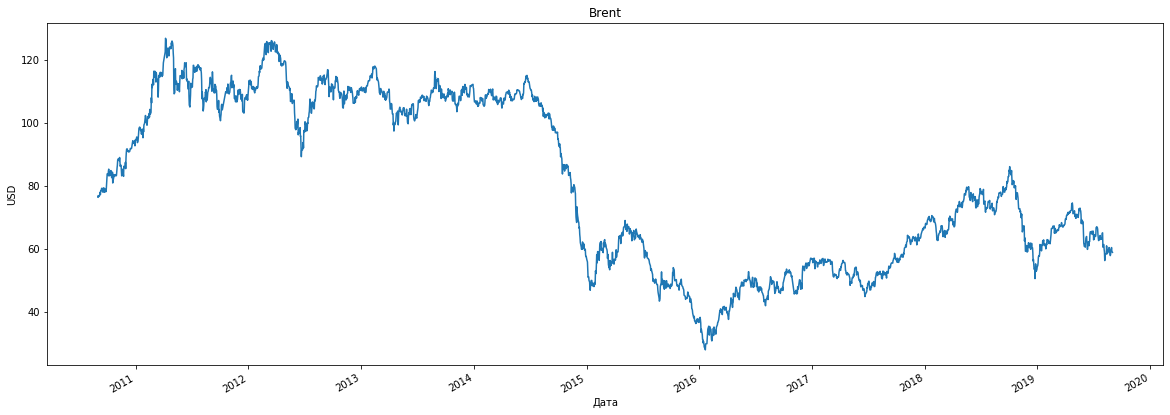

In [3]:
brent_data['Значение'].plot(figsize=(20, 7), title='Brent')
plt.ylabel('USD')

Добавим первую разность в датасет.

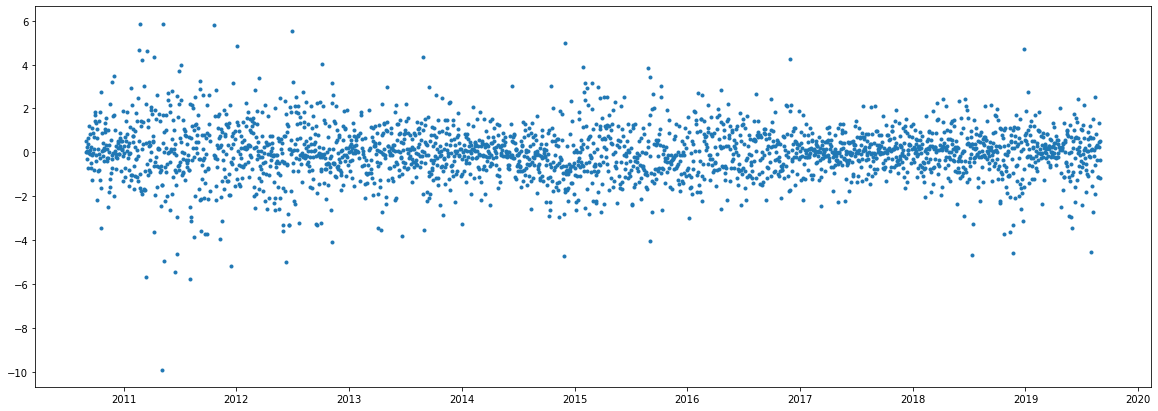

In [4]:
brent_data['diff1'] = 0
brent_data['diff1'][1:] = brent_data['Значение'].values[1:] - brent_data['Значение'].values[:-1]
plt.figure(figsize=(20, 7))
plt.plot(brent_data.iloc[:].index,brent_data['diff1'],'.')

### 2. Добавьте первые разности по стоимости доллара и евро к рублю

In [5]:
rub_usd=pd.read_excel('RC_F01_09_2010_T03_09_2019_doll.xlsx')
rub_usd.index = pd.to_datetime(rub_usd['data'].values).date
rub_usd.drop(['nominal', 'data', 'cdx'], axis=1, inplace=True)
# Сделаем заполнение всех дней, т.к. отсутствуют выходные
rub_usd = rub_usd.asfreq('D', method='pad')
rub_usd.rename(columns={'curs': 'curs_usd'}, inplace=True)
rub_usd.head()

,curs_usd
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-05,30.6922


In [6]:
rub_eur=pd.read_excel('RC_F01_09_2010_T03_09_2019_eur.xlsx')
rub_eur.index = pd.to_datetime(rub_eur['data'].values).date
rub_eur.drop(['nominal', 'data', 'cdx'], axis=1, inplace=True)
rub_eur = rub_eur.asfreq('D', method='pad')
rub_eur.rename(columns={'curs': 'curs_eur'}, inplace=True)
rub_eur.head()

,curs_eur
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-05,39.3505


Добавим курсы валют в датасет.

In [7]:
brent_data = brent_data.join(rub_usd)
brent_data = brent_data.join(rub_eur)

Добавим первую разницу курсов валют.

In [8]:
brent_data['usd_diff1'] = 0
brent_data['usd_diff1'][1:] = brent_data['curs_usd'].values[1:] - brent_data['curs_usd'].values[:-1]
brent_data['eur_diff1'] = 0
brent_data['eur_diff1'][1:] = brent_data['curs_eur'].values[1:] - brent_data['curs_eur'].values[:-1]
brent_data.drop(['dayofmonth', 'dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
                 'is_next_holiday', 'curs_usd', 'curs_eur'], axis=1, inplace=True)

In [9]:
brent_data.head()

,Значение,year,month,quarter,weekofyear,diff1,usd_diff1,eur_diff1
Дата,,,,,,,,
2010-09-01,76.37,2010,9,3,35,0.00,0.0000,0.0000
2010-09-02,76.89,2010,9,3,35,0.52,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,35,-0.32,-0.1143,0.1247
2010-09-04,76.62,2010,9,3,35,0.05,0.0064,0.0604
2010-09-05,76.63,2010,9,3,35,0.01,0.0000,0.0000


### 3. Сделайте ее перрасчет (ресемплинг) в представление по неделям.

In [10]:
brent_data_w = brent_data.resample('W').mean()
brent_data_w.head()

,Значение,year,month,quarter,weekofyear,diff1,usd_diff1,eur_diff1
Дата,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,0.052000,-0.034940,0.067560
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,0.288333,0.033583,-0.026467
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,-0.021667,0.031483,0.269967
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,0.118333,-0.022433,0.074733
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,0.791667,-0.073100,0.066783


При ресемплинге по неделям выскочило пустое значение в датасете. Заполним его предыдущим значением, т.к. при пропуске не работает градиентный бустинг.

In [11]:
brent_data_w.fillna(method='pad', inplace=True)

### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

Сформируем целевую переменную со сдвигом на 1 шаг и проведем стандартизацию.

In [12]:
scl_target=StandardScaler() 

h=1
target = brent_data_w['Значение'].values[h:].reshape((brent_data_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

Сформируем признаковый датасет со сдвигом на одну строку и проведем стандартизацию.

In [13]:
scl_x=StandardScaler() 

X = brent_data_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 8)

Видим, то размеры целевой переменной и признаков по строкам совпали.

Напишем функцию разделения данных на тренировоные и тестовые.

In [14]:
def split_data(data, split_date):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

Разобьем датасет и посмотрим на график.

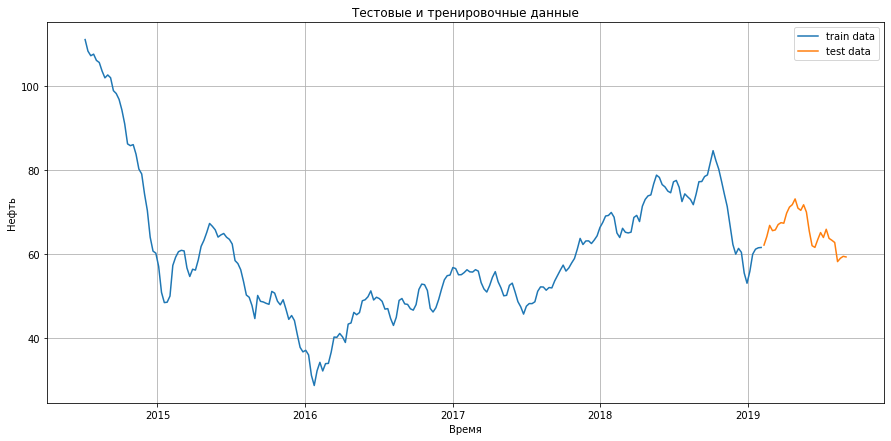

In [15]:
train, test = split_data(brent_data_w, -30)

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index[200:],train.iloc[200:,0], label='train data')
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.grid()
plt.legend()
plt.show()

In [16]:
X_train =X[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

Создадим сетку перебора параметров и обучим модель.

In [17]:
reg = GradientBoostingRegressor()
params = {
    'max_depth': [3, 4, 5],
    'n_estimators': [400, 450, 500, 550, 600, 650]    
}

model = GridSearchCV(reg, params, cv=5, n_jobs=-1)
# Теперь обучение. Ваш код здесь
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [18]:
model.best_params_

{'max_depth': 3, 'n_estimators': 450}

Предскажем значения на тренировочных данных и на тестовых.

In [19]:
y_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

Проведем визуализацию предсказания на тестовых данных.

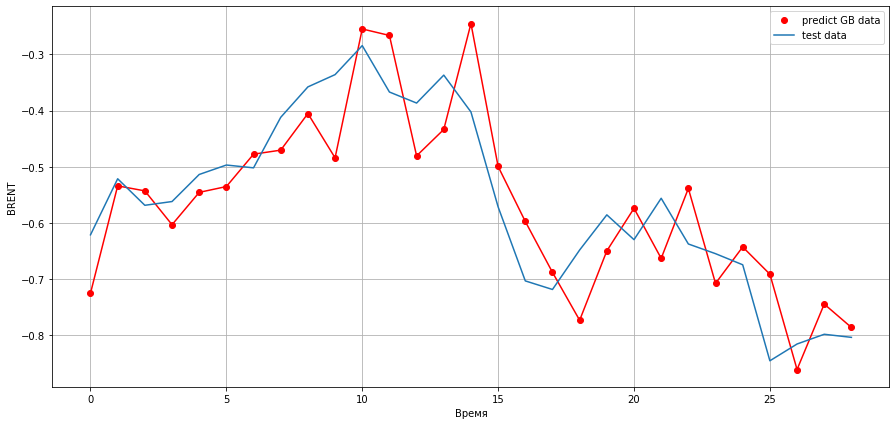

In [20]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred,'or', label='predict GB data')
plt.plot(y_test_pred,'r' )
plt.plot(y_test, label='test data')
plt.grid()
plt.legend()
plt.show()

И на тренировочных.

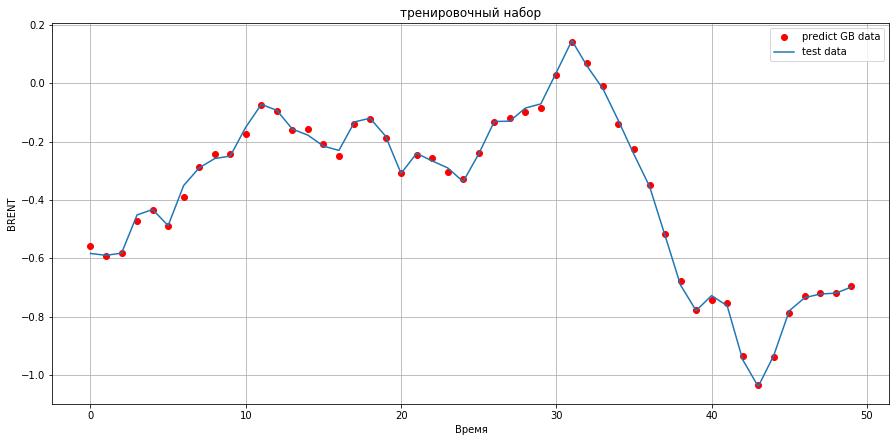

In [21]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred[-50:],'or', label='predict GB data' )
plt.plot(y_train[-50:], label='test data')
plt.grid()
plt.legend()
plt.show()

Видно, что на тренировочном наборе данных модель показывает отличные результаты, а на тестовых проглядывается общее направление, но сами результаты разняться. Посмотрим на ошибки при работе модели с тестовым набором.

In [22]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)

print('ошибка mse:  ', er_s,'\nошибка mae:  ', er_a,'\nоценка R2:   ', er_r2)

ошибка mse:   0.006624829625567174 
ошибка mae:   0.06981885506885988 
оценка R2:    0.7236783120020196


In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),
                                      y_pred = scl_target.inverse_transform(y_test_pred))

print('ошибка градиентного бустинга MAPE:  ', er_g,'%')

ошибка градиентного бустинга MAPE:   2.8303754566868373 %


### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Если просто взять сырые данные, сгенерировать небольшое количество признаков и на них построить модель, то ощибка будет значительно больше. В даном подходе мы видим ошибку всего в 2,8%.